In [54]:
import random
import sys
import time
import numpy as np
from games import Game, GameState

random.seed()

def minmax_decision(state, game, depthLim = 3):
    """Given a state in a game, calculate the best move by searching
    forward all the way to the terminal states. [Figure 5.3]"""

    player = game.to_move(state)

    def max_value(state, depthLimIn):
        if game.terminal_test(state) or depthLimIn <=0:
            return game.utility(state, player)
        v = -np.inf
        for a in game.actions(state):
            v = max(v, min_value(game.result(state, a), depthLimIn-1))
        return v

    def min_value(state, depthLimIn):
        if game.terminal_test(state) or depthLimIn <=0:
            return game.utility(state, player)
        v = np.inf
        for a in game.actions(state):
            v = min(v, max_value(game.result(state, a), depthLimIn -1))
        return v

    return max(game.actions(state), key=lambda a: min_value(game.result(state, a), depthLim))


def alpha_beta_search(state, game, depth_limit=10):
    """Search game to determine best action; use alpha-beta pruning.
    As in [Figure 5.7], this version searches all the way to the leaves."""

    player = game.to_move(state)

    def max_value(state, alpha, beta, depth):
        if depth <= 0 or game.terminal_test(state):
            return game.utility(state, player)
        v = -np.inf
        for a in game.actions(state):
            v = max(v, min_value(game.result(state, a), alpha, beta, depth - 1))
            if v >= beta:
                return v
            alpha = max(alpha, v)
        return v

    def min_value(state, alpha, beta, depth):
        if depth <= 0 or game.terminal_test(state):
            return game.utility(state, player)
        v = np.inf
        for a in game.actions(state):
            v = min(v, max_value(game.result(state, a), alpha, beta, depth - 1))
            if v <= alpha:
                return v
            beta = min(beta, v)
        return v

    best_score = -np.inf
    beta = np.inf
    best_action = None
    for a in game.actions(state):
        v = min_value(game.result(state, a), best_score, beta, depth_limit)
        if v > best_score:
            best_score = v
            best_action = a
    return best_action

def random_player(game, state, depth):
    """A player that chooses a legal move at random."""
    return random.choice(game.actions(state)) if game.actions(state) else None


def alpha_beta_player(game, state, depth):
    return alpha_beta_search(state, game, depth)


def minmax_player(game,state, depth):
    return minmax_decision(state,game, depth)


class Mancala(Game):
    def __init__(self, players = [alpha_beta_player, random_player], pits_per_player=6, stones_per_pit = 4, depth = 5):
        self.pits_per_player = pits_per_player
        self.board = [stones_per_pit] * ((pits_per_player+1) * 2)
        
        self.current_player = 1
        self.moves = []
        self.p1_pits_index = [0, self.pits_per_player-1]
        self.p1_mancala_index = self.pits_per_player
        self.p2_pits_index = [self.pits_per_player+1, len(self.board)-1-1]
        self.p2_mancala_index = len(self.board)-1

        # Total stones in the game (used in utility function)
        self.total_stones = pits_per_player * stones_per_pit
        
        self.board[self.p1_mancala_index] = 0
        self.board[self.p2_mancala_index] = 0
        
        self.initial = GameState(to_move = "1", utility = 0, board = self.board.copy(), moves=())
        self.state = self.initial
        
        self.players = players
        self.depth = depth
        
        # Track moves per player
        self.p1_moves = 0
        self.p2_moves = 0

    def valid_move(self, pit, state):
        """
        Function to check if the pit chosen by the current_player is a valid move.
        """
        if state.to_move == "1":
            pit_index = pit - 1
            if pit_index < self.p1_pits_index[0] or pit_index > self.p1_pits_index[1]:
                return False
        else:
            pit_index = self.p2_pits_index[1] - (pit - 1)
            if pit_index < self.p2_pits_index[0] or pit_index > self.p2_pits_index[1]:
                return False
        
        return list(state.board)[pit_index] > 0
    
    def terminal_test(self, state):
        """Function to verify if the game board has reached the winning state."""
        board = list(state.board) if state.board else self.board
        
        p1_pits_sum = sum(board[self.p1_pits_index[0]:self.p1_pits_index[1]+1])
        p2_pits_sum = sum(board[self.p2_pits_index[0]:self.p2_pits_index[1]+1])
        
        return p1_pits_sum == 0 or p2_pits_sum == 0
    
    def actions(self, state):
        """Return a list of the allowable moves at this point."""
        val = []
        for pit in range(1, self.pits_per_player + 1):
            if (self.valid_move(pit, state)): 
                val.append(pit)
        return val

    def utility(self, state, player):
        """Return the value of this final state to player."""
        board = list(state.board)

        # Compute sum of remaining stones on the board and calculate the ratio of stones left in the game
        # Serves as a ratio to reflect percentage left in the game
        p1_pits_sum = sum(board[self.p1_pits_index[0]:self.p1_pits_index[1]+1])
        p2_pits_sum = sum(board[self.p2_pits_index[0]:self.p2_pits_index[1]+1])

        stones_left_ratio = (p1_pits_sum + p2_pits_sum) / self.total_stones

        # If the game is at least 90% over, include weighting so utility function takes into consideration:
        # 1. The difference of stones on each side of the board 
        # 2. AND the difference of stones in each mancala
        
        if stones_left_ratio <= 0.1:
            weighted_utilities = [0.1 - stones_left_ratio, stones_left_ratio + 0.9]
        else:
            weighted_utilities = [0, 1]

        if (player == "1"): 
            return weighted_utilities[0] *  (p1_pits_sum - p2_pits_sum) + weighted_utilities[1] * (board[self.p1_mancala_index] - board[self.p2_mancala_index])
        else: return weighted_utilities[0] * (p2_pits_sum - p1_pits_sum) + weighted_utilities[1] * (board[self.p2_mancala_index] - board[self.p1_mancala_index])

    def result(self, state, move):
        """Return the state that results from making a move from a state."""
        board = list(state.board)
        
        if state.to_move == "1":
            pit_index = move - 1
            my_pits_range = self.p1_pits_index
            my_mancala = self.p1_mancala_index
            opponent_mancala = self.p2_mancala_index
        else:
            pit_index = self.p2_pits_index[1] - (move - 1)
            my_pits_range = self.p2_pits_index
            my_mancala = self.p2_mancala_index
            opponent_mancala = self.p1_mancala_index
        
        stones = board[pit_index]
        board[pit_index] = 0
        
        current_index = pit_index
        
        while stones > 0:
            current_index = (current_index + 1) % len(board)
            if current_index == opponent_mancala:
                continue
            board[current_index] += 1
            stones -= 1
        
        next_player = "2" if state.to_move == "1" else "1"
    
        # Continuation rule
        if current_index == my_mancala:
            next_player = state.to_move
        elif my_pits_range[0] <= current_index <= my_pits_range[1] and board[current_index] == 1:
            opposite_index = len(board) - 2 - current_index
            if board[opposite_index] > 0:
                captured = board[current_index] + board[opposite_index]
                board[current_index] = 0
                board[opposite_index] = 0
                board[my_mancala] += captured
        
        self.board = board.copy()
        
        return GameState(to_move=next_player, utility=0, board=tuple(board), moves=())
    
    def display(self):
        """
        Displays the board in a user-friendly format
        """
        player_1_pits = self.board[self.p1_pits_index[0]: self.p1_pits_index[1]+1]
        player_1_mancala = self.board[self.p1_mancala_index]
        player_2_pits = self.board[self.p2_pits_index[0]: self.p2_pits_index[1]+1]
        player_2_mancala = self.board[self.p2_mancala_index]

        print('P1             P2')
        print('      ____{}____     '.format(player_2_mancala))
        for i in range(self.pits_per_player):
            if i == self.pits_per_player - 1:
                print('{} -> |_{}_|_{}_| <- {}'.format(i+1, player_1_pits[i], 
                                player_2_pits[-(i+1)], self.pits_per_player - i))
            else:     
                print('{} -> | {} | {} | <- {}'.format(i+1, player_1_pits[i], 
                                player_2_pits[-(i+1)], self.pits_per_player - i))
            
        print('          {}           '.format(player_1_mancala))
        turn = 'P1' if self.state.to_move == "1" else 'P2'
        print('Turn: ' + turn)
        
    def play_game(self):
        """Play an n-person, move-alternating game."""
        while True:
            if self.state.to_move == "1":
                player = self.players[0]
                self.p1_moves += 1
            else:
                player = self.players[1]
                self.p2_moves += 1
                
            move = player(self, self.state, self.depth)
            self.state = self.result(self.state, move) 
            
            if self.terminal_test(self.state):
                score_diff = list(self.state.board)[self.p1_mancala_index] - list(self.state.board)[self.p2_mancala_index]
                return {
                    'score_diff': score_diff,
                    'p1_moves': self.p1_moves,
                    'p2_moves': self.p2_moves,
                    'total_moves': self.p1_moves + self.p2_moves,
                    'winner': 1 if score_diff > 0 else (2 if score_diff < 0 else 0)  # 0 = tie
                }


# Run trials and collect statistics
num_trials = 10000
plies = 1

score_diffs = []
p1_wins = 0
p2_wins = 0
ties = 0
p1_moves_list = []
p2_moves_list = []
total_moves_list = []

# --- ETA Setup ---
start_time = time.time()
# The trial count after which we consider the speed calculation stable enough
# to start showing ETA. (e.g., after 100 trials)
ETA_CALC_THRESHOLD = 100 

def format_time(seconds):
    """Converts a time in seconds to a human-readable HH:MM:SS format."""
    hours = int(seconds // 3600)
    minutes = int((seconds % 3600) // 60)
    sec = int(seconds % 60)
    return f"{hours:02d}:{minutes:02d}:{sec:02d}"
# -----------------

print(f"Running {num_trials} trials with depth = {plies}...")
# print(f"Player 1: Alpha-Beta | Player 2: Random\n")

for i in range(num_trials):
    mancala_game = Mancala(players = [alpha_beta_player, random_player], depth=plies)
    result = mancala_game.play_game()
    
    score_diffs.append(result['score_diff'])
    p1_moves_list.append(result['p1_moves'])
    p2_moves_list.append(result['p2_moves'])
    total_moves_list.append(result['total_moves'])
    
    if result['winner'] == 1:
        p1_wins += 1
    elif result['winner'] == 2:
        p2_wins += 1
    else:
        ties += 1

    # --- Progress Bar and ETA Update ---
    current_trials = i + 1
    percent = current_trials / num_trials * 100
    
    progress_str = f"\rProgress: {current_trials}/{num_trials} trials run ({percent:.2f}%)"
    
    if current_trials >= ETA_CALC_THRESHOLD:
        elapsed_time = time.time() - start_time
        # Speed in trials per second
        trials_per_second = current_trials / elapsed_time
        
        remaining_trials = num_trials - current_trials
        # Estimated remaining time in seconds
        eta_seconds = remaining_trials / trials_per_second
        
        eta_str = format_time(eta_seconds)
        elapsed_str = format_time(elapsed_time)
        
        # Add ETA and Elapsed Time to the progress string
        progress_str += f" | Elapsed: {elapsed_str} | ETA: {eta_str}"

    sys.stdout.write(progress_str)
    sys.stdout.flush()
    # -----------------------------------

# Print a final newline character to ensure the following output starts on a new line
print()

# Print results
print("============================================================")
print("TRIAL RESULTS")
print("============================================================")
print(f"\nTotal Games Played: {num_trials}")
print(f"\nWin Statistics:")
print(f"  Player 1 Wins: {p1_wins} ({p1_wins/num_trials*100:.1f}%)")
print(f"  Player 2 Wins:      {p2_wins} ({p2_wins/num_trials*100:.1f}%)")
print(f"  Ties:               {ties} ({ties/num_trials*100:.1f}%)")

print(f"\nScore Difference Statistics (P1 - P2):")
print(f"  Total Sum:      {sum(score_diffs)}")
print(f"  Average:        {np.mean(score_diffs):.2f}")
print(f"  Std Dev:        {np.std(score_diffs):.2f}")
print(f"  Min:            {min(score_diffs)}")
print(f"  Max:            {max(score_diffs)}")

print(f"\nMoves Statistics:")
print(f"  Average P1 Moves per Game:     {np.mean(p1_moves_list):.2f}")
print(f"  Average P2 Moves per Game:     {np.mean(p2_moves_list):.2f}")
print(f"  Average Total Moves per Game: {np.mean(total_moves_list):.2f}")
print(f"  Total P1 Moves (all games):    {sum(p1_moves_list)}")
print(f"  Total P2 Moves (all games):    {sum(p2_moves_list)}")
print(f"  Total Moves (all games):       {sum(total_moves_list)}")

print("============================================================")

Running 10000 trials with depth = 1...
Progress: 10000/10000 trials run (100.00%) | Elapsed: 00:00:23 | ETA: 00:00:00
TRIAL RESULTS

Total Games Played: 10000

Win Statistics:
  Player 1 Wins: 9985 (99.9%)
  Player 2 Wins:      14 (0.1%)
  Ties:               1 (0.0%)

Score Difference Statistics (P1 - P2):
  Total Sum:      232179
  Average:        23.22
  Std Dev:        6.06
  Min:            -9
  Max:            41

Moves Statistics:
  Average P1 Moves per Game:     19.14
  Average P2 Moves per Game:     13.88
  Average Total Moves per Game: 33.03
  Total P1 Moves (all games):    191437
  Total P2 Moves (all games):    138826
  Total Moves (all games):       330263


## Step 3: Random vs Random (100 games)

**Win Statistics:**
- Player 1 Wins: 48 (48.0%)
- Player 2 Wins: 48 (48.0%)
- Ties: 4 (4.0%)

**Moves per Game:**
- Average Total Moves: 44.29

**Execution Time:** < 1 second

## Step 5: Minimax AI vs Random - 5 plies (100 games)

**Win Statistics:**
- AI Wins: 100 (100.0%)
- Random Wins: 0 (0.0%)

**Moves per Game:**
- Average Total Moves: 37.91

**Execution Time:** 00:00:52

**Analysis:**
The minimax AI at 5 plies wins every game against the random player, performing significantly better than random chance. Games finish faster than random vs random (37.91 vs 44.29 moves), showing the AI plays more efficiently.

## Step 7: Alpha-Beta AI vs Random - 5 plies (100 games)

**Win Statistics:**
- AI Wins: 100 (100.0%)
- Random Wins: 0 (0.0%)

**Moves per Game:**
- Average Total Moves: 38.99

**Execution Time:** 00:00:06

**Analysis:**
The alpha-beta AI at 5 plies also wins every game with similar performance to minimax. The alpha-beta implementation is approximately 8.7x faster than minimax (6 seconds vs 52 seconds), demonstrating effective pruning while achieving identical win rates.

## Step 8: Alpha-Beta AI vs Random - 10 plies (100 games)

**Win Statistics:**
- AI Wins: 100 (100.0%)
- Random Wins: 0 (0.0%)

**Moves per Game:**
- Average Total Moves: 33.48

**Execution Time:** 00:11:22

**Speed Comparison:**
- Minimax at 5 plies: 52 seconds (0.52 sec/game)
- Alpha-Beta at 5 plies: 6 seconds (0.06 sec/game)
- Alpha-Beta at 10 plies: 682 seconds (6.82 sec/game)

**Projected Minimax at 10 plies:**
Based on the scaling factor from 5 to 10 plies, minimax would take approximately 98-100 minutes for 100 games.

**Analysis:**
At 10 plies, the AI maintains 100% win rate but finishes games even faster (33.48 moves vs 37.91-38.99 at 5 plies). The deeper search allows more efficient winning strategies.

## Win Rate by Search Depth

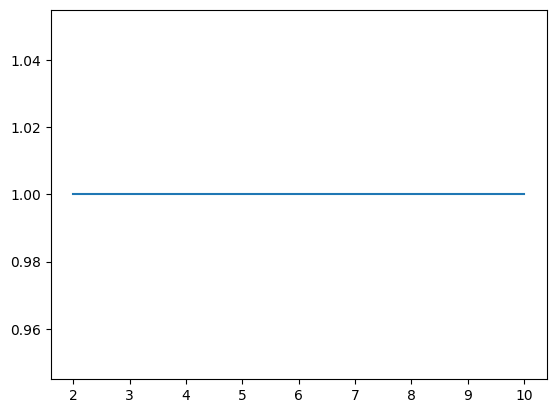

In [31]:
import numpy as np
import matplotlib.pyplot as plt

num_trials = 100

win_percentage_per_ply = []

plys_to_iterate_over = [2, 5, 10]

for i in plys_to_iterate_over:
    p1_wins = 0
    p2_wins = 0
    ties = 0
    for j in range(num_trials):
        mancala_game = Mancala(players = [alpha_beta_player, random_player], depth = i)
        result = mancala_game.play_game()

        if result['winner'] == 1:
            p1_wins += 1
        elif result['winner'] == 2:
            p2_wins += 1
        else:
            ties += 1

    win_percentage_per_ply.append(p1_wins / num_trials)
    

plt.plot(plys_to_iterate_over, win_percentage_per_ply)

| Depth | AI Win Rate |
|-------|-------------|
| 2 plies | 100.0%   |
| 5 plies | 100.0% |
| 10 plies | 100.0% |

**Explanation:**
Across 2 plies, 5 plies, and 10 ply depths the AU achieve 100% win rates against random play. However, increasing depth from 5 to 10 plies reduces average game length from ~35 moves  to ~34 moves, and finally to 33.48 moves, indicating the deeper search finds more efficient paths to victory. The trade-off is significantly longer computation time (6 seconds for 1 ply vs 9 seconds for 5 plies vs 682 seconds for 10 plies). 

**Analysis of Trending:**
Note that across 2, 5, and 10 plies, the Alpha-Beta player wins 100% of all 100 games in all three cases. This is expected, becuase the algorithm is far superior to a player playing at random. In fact, when running 10,000 trials at 1 ply, the random player only won 14 games and tied 2 times. When increasing the amount of plies, the odds of the random player winning by chance become exponentially more slim.

## Step 9: Extra Credit - Updating the Utility Function

For the first of the two extra credit opportunites, we decided of a way to update the utility function. The idea was to add a weighting system to what the AI values. Instead of the AI focusing only on the difference in the mancala pits, we also wanted to incorporate the fact that when one player clears their side of the board, all remaining stones on the other side of the board are immidiately collected and added to their mancala. If we were able to correctly weight the utility function so the AI cared about the mancala difference AND keeping stones on their side of the board towards the end of the game, we predicted we could improve the AI's performance.

After a lot of trial and error, we decided on this:

In each utility calculation, we sum across all regular pits and divide by the total number of stones in the game, which serves as a fraction that represents how much of the game has progressed. For the first 90% of the game, we use the original utility function, considering only the difference between stones in the mancala. However, in the last 10% of the game, the AI begins to increasingly also "care" about keeping stones on its side of the board. In doing this, we found a slight improvement in a number of statistics. See below:

## Changed Utility Function Statistics

<b> <u> Running 10,000 trials with 1 ply with our original utility function yields: </u> </b>

<u >Win Statistics: </u>

  Player 1 Wins: 9982 (99.8%) 

  Player 2 Wins:      15 (0.1%)

  Ties:               3 (0.0%)

<u> Score Difference Statistics (P1 - P2): </u>

  Total Sum:      231388

  Average:        23.14

  Std Dev:        6.17

  Min:            -10

  Max:            40

<u> Moves Statistics: </u>

  Average P1 Moves per Game:     19.16

  Average P2 Moves per Game:     13.88

  Average Total Moves per Game: 33.04

  Total P1 Moves (all games):    191606

  Total P2 Moves (all games):    138782

  Total Moves (all games):       330388

<b> <u> With our updated utlity function, running 10,000 trials with 1 ply instead yields: </b> </u>

<u> Win Statistics: </u>

  Player 1 Wins: 9985 (99.9%)

  Player 2 Wins:      14 (0.1%)

  Ties:               1 (0.0%)

<u> Score Difference Statistics (P1 - P2): </u>

  Total Sum:      232179

  Average:        23.22

  Std Dev:        6.06

  Min:            -9

  Max:            41

<u> Moves Statistics: </u>

  Average P1 Moves per Game:     19.14

  Average P2 Moves per Game:     13.88

  Average Total Moves per Game: 33.03

  Total P1 Moves (all games):    191437

  Total P2 Moves (all games):    138826

  Total Moves (all games):       330263

Although a very minor improvement, you can see that our updated utility function resulted in:

Player 1 Wins: `9982 (99.8%)` -> `9985 (99.9%)`

Average P1 Moves per Game: `19.16` -> `19.14`

Average of Score Difference: `23.14` -> `23.22`

Std Dev: `6.17` -> `6.06`

Essentially, these numbers tell us that our AI player is (on average) now winning more games by a higher margin in less moves. The standard deviation also went down, meaning that our games are playing more consistently.

## Step 10: Extra Credit: Implement the continuation rule fully

For the second extra credit opportunity, we implemented the continuation rule.

Implementing this was simple, we simply added this condition to our `result` function:

`if current_index == my_mancala: 
    next_player = state.to_move`

If the while loop ends on the player's mancala, we simply revert the operation done above this code to flip the player, effectively flipping the next_player back to the current player and maintaining their turn. 

## Analysis of implementing the continuation rule

# Monte Carlo Tree Search Trials Comparison
## 10 Plies - With vs Without Rule Change

---

## WITH CHANGE

**Progress:** 100/100 trials run (100.00%) | Elapsed: 00:11:22 | ETA: 00:00:00

### Trial Results

**Total Games Played:** 100

#### Win Statistics
- **Player 1 Wins:** 100 (100.0%)
- **Player 2 Wins:** 0 (0.0%)
- **Ties:** 0 (0.0%)

#### Score Difference Statistics (P1 - P2)
- **Total Sum:** 2192
- **Average:** 21.92
- **Std Dev:** 4.96
- **Min:** 7
- **Max:** 34

#### Moves Statistics
- **Average P1 Moves per Game:** 17.16
- **Average P2 Moves per Game:** 16.32
- **Average Total Moves per Game:** 33.48
- **Total P1 Moves (all games):** 1716
- **Total P2 Moves (all games):** 1632
- **Total Moves (all games):** 3348

---

## BEFORE CHANGE

**Progress:** 100/100 trials run (100.00%) | Elapsed: 00:13:20 | ETA: 00:00:00

### Trial Results

**Total Games Played:** 100

#### Win Statistics
- **Player 1 Wins:** 100 (100.0%)
- **Player 2 Wins:** 0 (0.0%)
- **Ties:** 0 (0.0%)

#### Score Difference Statistics (P1 - P2)
- **Total Sum:** 2282
- **Average:** 22.82
- **Std Dev:** 4.85
- **Min:** 11
- **Max:** 33

#### Moves Statistics
- **Average P1 Moves per Game:** 16.75
- **Average P2 Moves per Game:** 15.93
- **Average Total Moves per Game:** 32.68
- **Total P1 Moves (all games):** 1675
- **Total P2 Moves (all games):** 1593
- **Total Moves (all games):** 3268

---

## Summary Comparison

| Metric | With Change | Before Change | Difference |
|--------|-------------|---------------|------------|
| Avg Score Difference | 21.92 | 22.82 | -0.90 |
| Std Dev | 4.96 | 4.85 | +0.11 |
| Avg Total Moves | 33.48 | 32.68 | +0.80 |
| Execution Time | 00:11:22 | 00:13:20 | -1:58 (faster) |


Player 1 takes more moves as since they realise they can go again if they end in their own pit, so they try and do that, which causes P1 to move more, and win more too (though the win-rates are equal as we only ran 100 trials due to high-ply counts).